In [2]:
import os
import sys
import ast
import cv2
import json
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
sys.path.append('./')
from utils import normalize_image, plot_image, plot_images

In [3]:
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11'
# root_dir = '/data/jupiter/datasets/Jupiter_train_v5_11_20230508'
# root_dir = '/data2/jupiter/datasets/Jupiter_train_v6_2'
root_dir = '/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1'
# root_dir = '/data2/jupiter/datasets/halo_rgb_stereo_test_v6_1'
# root_dir = '/data/jupiter/datasets/20230823_labeled_right_images_12k'
# root_dir = '/data/jupiter/li.yu/data/left_and_right_labels_samples'
# root_dir = '/data/jupiter/li.yu/data/Jupiter_2022_Dust_Humans_Unfiltered_partiallabeled'
# csv = os.path.join(root_dir, '642ba9506651c8d5688518e0_master_annotations_ppcutnpastecolumns.csv')
csv = os.path.join(root_dir, 'master_annotations_dedup.csv')
# csv = os.path.join(root_dir, 'v61base_epoch0_5_30_focal05_master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (1,2,23,81,92,93,94,95,96,98,99,101,102,103,104,105,106,107,108,109,119,152,156,157,162,173,176,179,180,186,188,198,199,201,202,203,204,224,229,230,231,234,236,238,239,250,251,253,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,274,278,279,280,283,284,285,287) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(147222, 325)

In [15]:
# load cutnpaste columns
# df2 = pd.read_parquet('/data2/jupiter/datasets/Jupiter_train_v6_2/cache/cutnpaste_961706335.parquet')
df2 = pd.read_csv('/data2/jupiter/datasets/halo_rgb_stereo_train_v6_1/cache/cutnpaste_1553242183.csv')
df2.shape

(147222, 344)

In [16]:
set(df2.columns) - set(df.columns)

{'brightness',
 'color_transfer_npz_save_path',
 'humans_max_col',
 'humans_max_row',
 'humans_min_col',
 'humans_min_row',
 'humans_pixel_count',
 'is_humans_present_in_annotations',
 'is_laying_down_human',
 'is_multi_human',
 'is_standing_human',
 'is_tractors_or_vehicles_present_in_annotations',
 'label_counts',
 'occluded_humans',
 'tractors_or_vehicles_max_col',
 'tractors_or_vehicles_max_row',
 'tractors_or_vehicles_min_col',
 'tractors_or_vehicles_min_row',
 'tractors_or_vehicles_pixel_count'}

In [4]:
df2['is_humans_present_in_annotations'] = df2['humans_pixel_count'] > 0
df2['is_tractors_or_vehicles_present_in_annotations'] = df2['tractors_or_vehicles_pixel_count'] > 0
print(df2.columns)
common_columns = ['brightness', 'label_counts', 
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations']
common_columns = set(common_columns).intersection(list(df.columns))
# drop columns in df
df.drop(common_columns, axis=1, inplace=True)
print(df.shape)
df1 = df.merge(df2, on='unique_id')
print(df1.shape)

Index(['brightness', 'label_counts', 'Airborne-debris', 'Driveable',
       'humans_pixel_count', 'humans_max_row', 'humans_min_row',
       'humans_max_col', 'humans_min_col', 'is_multi_human',
       'is_standing_human', 'is_laying_down_human', 'occluded_humans',
       'tractors_or_vehicles_pixel_count', 'tractors_or_vehicles_max_row',
       'tractors_or_vehicles_min_row', 'tractors_or_vehicles_max_col',
       'tractors_or_vehicles_min_col', 'unique_id',
       'is_humans_present_in_annotations',
       'is_tractors_or_vehicles_present_in_annotations'],
      dtype='object')
(318874, 416)
(318874, 436)


In [13]:
# update stereo_pipeline_npz_save_path with clean depth
df2 = pd.read_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean.csv')
print(df2.shape)
df1.drop(columns=['stereo_pipeline_npz_save_path'], axis=1, inplace=True)
print(df1.shape)
df1 = df1.merge(df2[['id', 'stereo_pipeline_npz_save_path']], on='id')
print(df1.shape)
df1.to_csv('/data2/jupiter/datasets/Jupiter_train_v6_2/master_annotations_20231019_clean_fl05.csv', index=False)

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,40,59,60,61,62,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,81,82,83,84,85,86,87,88,89,90,91,110,111,112,113,115,116,117,118,119,120,121,122,123,124,125,144,145,146,147,149,150,151,152,153,154,155,156,157,158,159,161,162,163,164,166,167,168,169,170,171,172,173,174,175,176,178,179,180,181,183,184,185,186,187,188,189,190,191,192,193,224,226,228,231,248,252,255,256,262,263,264,268,309,320,325,327,328,338,339,347,355,371,372,374,375,377,378) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(321638, 425)
(318874, 435)
(318874, 436)


In [15]:
# df2['stereo_pipeline_npz_save_path'] = df2['stereo_pipeline_npz_save_path'].apply(lambda p: p[43:])
# df2['rectified_label_save_path'] = df2['rectified_label_save_path'].apply(lambda p: p[43:])
# df2 = df2.drop('color_transfer_npz_save_path', axis=1)
# df2.iloc[0].stereo_pipeline_npz_save_path, df2.iloc[0].rectified_label_save_path

('processed/images/614d0eb90f7787d7ba7d1e43/stereo_output.npz',
 'processed/images/614d0eb90f7787d7ba7d1e43/rectification_output_61dd087a50a352ea47e1e4b4.npz')

64d26cbdbcb05e3b0204b073 T01


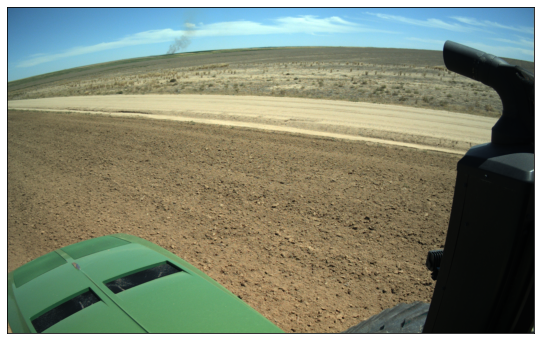

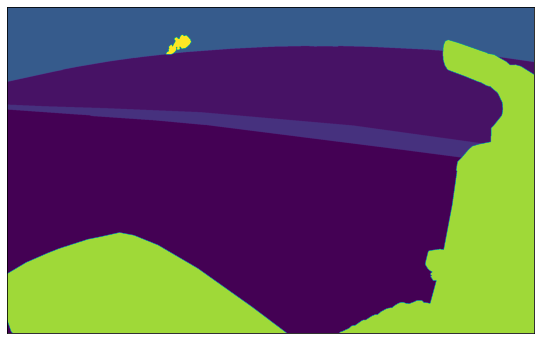

In [13]:
# sub_df = df2[df2.camera_pod == 'implement_pod'].sample(5)
# sub_df = df[(~df.unique_id.isin(negative_ids)) & (df.unique_id.isin(negative_ids_depth30))].sample(2)
# sub_df = df[df.unique_id == '64d6542284dac3a508c73ae0_T14_T15']
sub_df = df.sample(1)
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
show_image, show_label = False, False
show_debayered_rgb, show_raw_label = True, True
show_pred_result = False
dataset = ''
for i, row in sub_df.iterrows():
    # print(row.id, row.gt_dust_ratio, row.pred_dust_ratio)
    print(row.id, row.camera_location)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        lbl = np.load(label_path)['left']
        labels = np.unique(lbl)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(lbl))
        plot_image(lbl)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        plot_image(label)

    if show_pred_result:
        result_path = os.path.join(pred_dir, 'output_visualization', row.id+'.png')
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

In [5]:
image.dtype, image.shape, image.max()

(dtype('uint8'), (1204, 1944, 3), 255)

## Get categorical labels for training set

In [6]:
categorical_labels_map = {'objects': {'Utility pole', 'Immovable Objects', 'Buildings', 'Animals', 'Tile-Inlet'}, 'humans': {'Humans'}, 
                            'vehicles': {'Tractors or Vehicles'}, 'dust': {'Heavy Dust'}, 'birds': {'Birds'}, 'airborne': {'Airborne Debris'}}
categorical_object_labels = {v for k,vs in categorical_labels_map.items() for v in vs}
categorical_object_labels

{'Airborne Debris',
 'Animals',
 'Birds',
 'Buildings',
 'Heavy Dust',
 'Humans',
 'Immovable Objects',
 'Tile-Inlet',
 'Tractors or Vehicles',
 'Utility pole'}

In [22]:
def get_categorical_labels(root_dir, dataset, row):
    label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
    labels = np.unique(label)
    label_map = row.label_map
    label_str_2_id = {label_map[str(i)]: i for i in labels if i != 0}
    # print(row.unique_id, label.shape, labels, label_str_2_id)
    # process object class
    for object_label, subs in categorical_labels_map.items():
        object_ids = [label_str_2_id[sub] for sub in subs if sub in label_str_2_id]
        object_pixel_count = 0
        if len(object_ids) > 0:
            object_pixel_count = np.count_nonzero(np.isin(label, object_ids))
        row[object_label] = object_pixel_count
    return row

# get_categorical_labels(root_dir, dataset, df.iloc[100])

In [15]:
# df = df.apply(lambda row: get_categorical_labels(root_dir, dataset, row), axis=1)
print(df.shape)
df[['unique_id'] + list(categorical_labels_map.keys())].to_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv', index=False)

(147222, 325)


In [17]:
count_df = pd.read_csv('/data/jupiter/li.yu/data/halo_rgb_stereo_train_test/train_v6_1_categorical_count.csv')
# count_df = df[list(categorical_labels_map.keys())]
count_df.head()

,unique_id,objects,humans,vehicles,dust,birds,airborne
0,64d26cbdbcb05e3b0204b073_T01_T03,0,0,0,3223,0,0
1,64d26d94dbc0a3f0144aa7cd_T01_T03,0,0,0,0,0,0
2,64d26dd8345f97672661040f_T01_T03,0,0,0,0,0,0
3,64d26e196ee204e8591849d6_T01_T03,268,0,0,0,0,0
4,64d26f0a91294bf9055c72ef_T01_T03,0,0,0,0,0,0


In [36]:
for sub in categorical_labels_map.keys():
    print(sub, len(count_df[count_df[sub] > 0]))

objects 114611
humans 29378
vehicles 23479
dust 21119
birds 955
airborne 11536
